# <center>⚡️🏁 Quick start - тестируем простое решение</center>

In [ ]:
!pip install numpy pandas catboost -q
#!ls ../data/ # проверяем наличие данных

In [ ]:
import numpy as np
import pandas as pd

## Анализируем данные о машинах car_info

🚗 Главное описание машин с информацией о поломках для обучения / прогноза - `car_train.csv` / `car_test.csv`.

**Пояснение столбцов:**
- `car_id` - идентификатор машины
- `model` / `car_type` / `fuel_type`- марка, класс и тип топлива машины
- `car_rating` / `riders` - общий рейтинг  и общее число поездок к концу 2021-го кода.
- `year_to_start` / `year_to_work` - года выпуска машины и начала работы в автопарке
- `main_city` - город пребывания машины. (Москва или Питер)
- `target_reg` - количество дней до поломки.
- `target_class` - класс поломки (всего 9 видов)

(2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
177,V15348382y,Renault Sandero,standart,petrol,4.12,2015,73441,2018,40.92,engine_overheat
946,Z-7340686v,Renault Sandero,standart,petrol,5.66,2014,63799,2019,34.19,gear_stick
1204,i-1870741R,Kia Rio X,economy,petrol,5.58,2013,42608,2020,45.50,engine_check


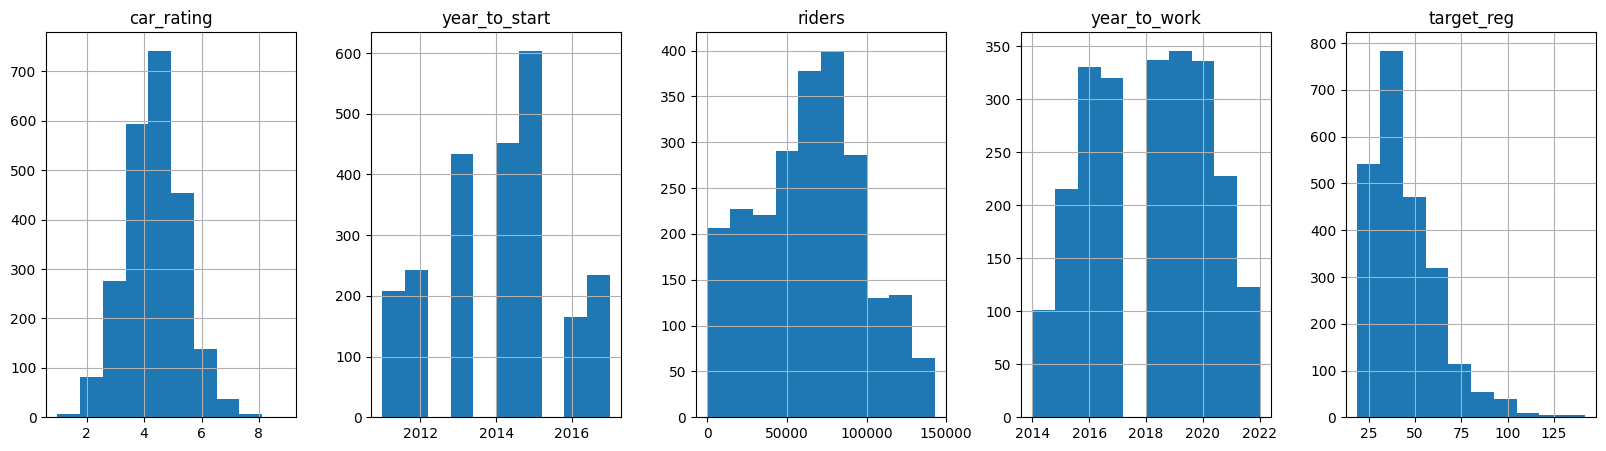

In [ ]:
data_root = "https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/"
path = data_root + 'car_train.csv'
train = pd.read_csv(path)
print(train.shape)
train.hist(figsize=(20, 5), layout = (-1, 5))
train.sample(3)

In [ ]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.946735
std,0.996954,1.685852,33755.012096,2.159484,17.579568
min,0.980000,2011.000000,23.000000,2014.000000,18.920000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.670000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.170000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.790000
max,8.900000,2017.000000,142862.000000,2022.000000,141.630000


In [ ]:
path = data_root + 'car_test.csv'
test = pd.read_csv(path)
print(test.shape)
test.sample(3)

(1913, 8)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
118,V56226787D,Smart ForFour,economy,petrol,3.80,2017,112276,2018
270,F-5963184s,VW Polo VI,economy,petrol,5.24,2015,83472,2018
1161,z42577454j,Renault Kaptur,standart,petrol,3.48,2015,89628,2017


## Классифицируем признаки на типы

In [ ]:
features2drop = ['car_id'] # то что надо выбросить
targets = ['target_class', 'target_reg'] # таргеты
cat_features = ['car_type', 'fuel_type', 'model'] # категориальные признаки

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


## Объявляем модель для кросс-валидации

Чтобы в дальнейшем было удобно обучать и инференсить модели, обученные при помоищ кросс-валидации, напишем под это дело отдельный класс. Он будет принимать модель (в нашем случае `catboost`), и обучать несколько ее вариации - отдельная модель на каждый фолд. Во время инференса будем просто брать тот класс, за который проголосовало наиобольшее кол-во моделей.

In [ ]:
from sklearn.model_selection import StratifiedKFold
import copy
from collections import Counter
from sklearn.metrics import accuracy_score

class CvModel:
    def __init__(self, clf):
        self.models = []
        self.clf = clf
        self.scores = []

    def fit(self, X, y, cv=5):
        self.models = []
        self.scores = []

        skf = StratifiedKFold(n_splits=cv)
        for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            now_model = copy.deepcopy(self.clf)
            X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

            now_model.fit(X_train, y_train,
                          eval_set=(X_val, y_val),
                          early_stopping_rounds=150,
                          verbose=False)

            acc = accuracy_score(now_model.predict(X_val), y_val)
            print(f'Fold {i}/{cv} acc = {acc}')

            self.scores.append(acc)
            self.models.append(now_model)
        print('Mean acc = {}'.format(np.mean(self.scores)))

    def predict_proba(self, X):
        if len(self.models) == 0:
            raise Exception("There is not fitted model")

        res = [model.predict_proba(X) for model in self.models]
        return np.sum(res, axis=0)

    def predict(self, X):
        if len(self.models) == 0:
            raise Exception("There is not fitted model")

        preds = np.concatenate([model.predict(X).reshape(-1, 1) for model in self.models], axis=1)
#         print(preds.shape)
        res = [Counter(el).most_common()[0][0] for el in preds]
        return res

## Обучаем Catboost и делаем прогноз на тест

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [ ]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

In [ ]:
params_cat = {
    "n_estimators": 1500,
    "learning_rate": 0.03,
    "depth": 5,
    "use_best_model": True,
    "cat_features": cat_features,
    "text_features": [],
    "l2_leaf_reg": 1,
    "bagging_temperature": 2,
    "random_state": 42,
    "loss_function": 'MultiClass',
    'eval_metric': 'Accuracy',
}

In [ ]:
clf = CatBoostClassifier(**params_cat)
cv_model = CvModel(clf)

In [ ]:
cv_model.fit(X, y)

Fold 0/5 acc = 0.13034188034188035
Fold 1/5 acc = 0.1346153846153846
Fold 2/5 acc = 0.14775160599571735
Fold 3/5 acc = 0.14989293361884368
Fold 4/5 acc = 0.14132762312633834
Mean acc = 0.14078588553963284


In [ ]:
test['target_class'] = cv_model.predict(test[filtered_features])
#test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v1.csv', index=False)
test[['car_id', 'target_class']].to_csv('simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


## Добавим информацию про поездки из rides_info


🏇 Информация про поездки - `rides_info.csv`.  **Пояснение столбцов:**
- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения машины водителя, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы).


In [ ]:
path = data_root + 'rides_info.csv'
rides = pd.read_csv(path)
rides.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
399911,t10596009J,c-7401486X,y1z,2020-02-01,6.32,113,1237,46,77.089245,0,917.789968,0,19.355723,4.471
404195,M36042624o,c22334367p,V1y,2020-03-29,9.35,25,271,38,48.000000,2,484.362149,0,3.878435,25.628
209265,r87867134Z,O22101080f,h1a,2020-03-03,3.69,65,1035,52,106.000000,3,2710.832758,0,-11.827660,-39.508
633511,i17228160O,s22484554J,H1L,2020-03-21,1.38,35,416,82,148.777634,0,2946.721020,0,-21.534503,8.581
515071,Q25707401z,k-6134216L,h1E,2020-01-17,1.60,5,75,28,113.410958,0,131.717539,0,0.693062,18.794


In [ ]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('rating', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'),
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173


In [ ]:
def add_featues(df):

    if 'mean_rating' not in df.columns:
        data = df.merge(rides_df_gr, on = 'car_id', how = 'left')
    else:
        data = df.copy()

    data['sum_rating'] = data['mean_rating'] * data['riders']
    data['year_in_work'] = data['year_to_work'] - data['year_to_start']
    data['mean_distance'] = data['distance_sum'] / data['year_in_work']
    data['riders_per_year'] = data['riders'] / data['year_in_work']

    return data


train = add_featues(train)
test = add_featues(test)

In [ ]:
train.sample(2)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,sum_rating,year_in_work,mean_distance,riders_per_year
2116,P19653432E,Hyundai Solaris,economy,petrol,3.5,2015,76001,2018,54.36,engine_ignition,...,1.215522e+07,0.1,190.443106,-2.415873,174,173,314779.544080,3,4.051739e+06,25333.666667
438,Z16147645X,Skoda Rapid,economy,petrol,3.7,2015,81430,2021,26.61,engine_fuel,...,1.244182e+07,0.1,158.936072,7.184481,174,167,343381.886207,6,2.073637e+06,13571.666667


In [ ]:
# train.to_csv('../tmp_data/quickstart_train.csv', index=False)

In [ ]:
# test.to_csv('../tmp_data/quickstart_tra.csv', index=False)

# Снова обновляем типы фичей

In [ ]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 15 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'sum_rating', 'year_in_work', 'mean_distance', 'riders_per_year']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


# Обучаем Catboost на новых данных и делаем новый прогноз

In [ ]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

In [ ]:
clf = CatBoostClassifier(**params_cat)
cv_model = CvModel(clf)

In [ ]:
cv_model.fit(X, y)

Fold 0/5 acc = 0.7841880341880342
Fold 1/5 acc = 0.8034188034188035
Fold 2/5 acc = 0.8137044967880086
Fold 3/5 acc = 0.8394004282655246
Fold 4/5 acc = 0.7987152034261242
Mean acc = 0.807885393217299


In [ ]:
test['target_class'] = cv_model.predict(test[filtered_features])
#test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v2.csv', index=False)
test[['car_id', 'target_class']].to_csv('simple_baseline_v2.csv', index=False)
print('CSV file saved!')

CSV file saved!


## Смотрим на важность признаков

In [ ]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 19.8 MB/s eta 0:00:00


In [ ]:
import shap
from catboost import Pool

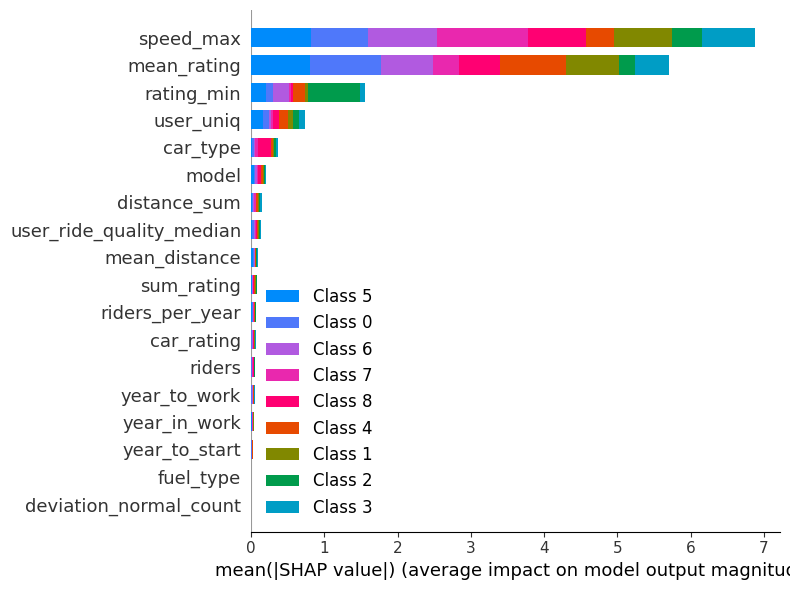

In [ ]:
# Построим усредненный shap values
explainer = shap.TreeExplainer(cv_model.models[0])
shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))

shap.summary_plot(shap_values, X, plot_size=0.25,)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
invalid value encountered in subtract


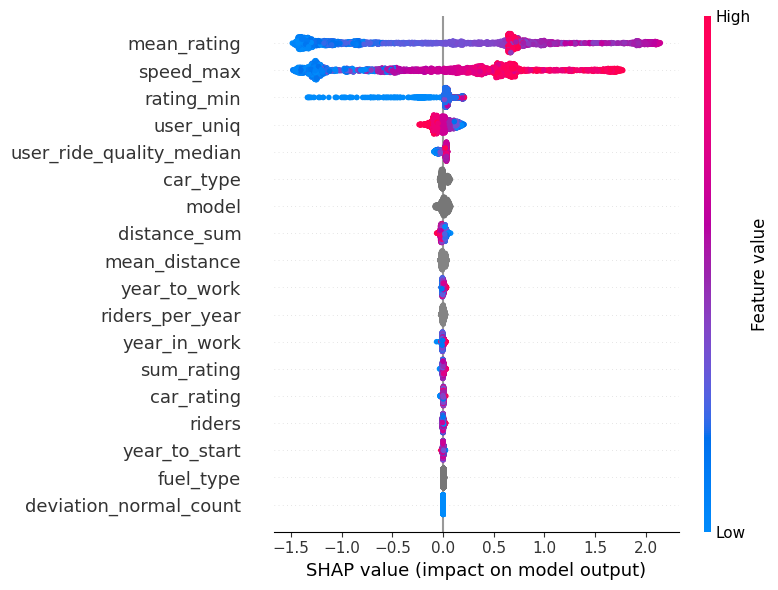

In [ ]:
# построем shap values отдельно для нулевого класса
shap.summary_plot(shap_values[0], X, plot_size=0.25,)

## Что дальше? Зашли решение на Kaggle

- Нажимаем `Save Version`
- Проверяем, что в `Advanced Settings` выбрано - всегда сохранять результаты ноутбука.
- Тип сохранения `Save & Run All (Commit)`
- Жмем окончательно кнопку `Save`

**Как еще можно улучшить это решение?**

- Во время кросс валидации делать не hard, а soft voiting
- Нагенерить новых фичей (может быть даже при помощи `AutoML`)
- Присоединить сюда информацию о машинах из модуля про парсинг
- Перебрать гиперпараметры при помощи `Optuna`
- Сбледнить/застекать модели